# KMeans Clustering

In [1]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

NameError: name 'time' is not defined

## Description

- Try different clusterings 

In [2]:
import feather
import multiprocessing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import Normalizer, MaxAbsScaler

import hdbscan

## Load Data

In [3]:
path = '../data/processed/EDY/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

(2173160, 3)

In [4]:
path = '../data/processed/EDY/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(19220, 10)

In [5]:
path = '../data/processed/EDY/holdings_s.npz'
holdings_t = sparse.load_npz(path)
holdings_t.shape

(19220, 10445)

In [6]:
path = '../data/processed/EDY/holdings_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(19220, 10445)

## Cluster

/Users/alexandersteeb/.virtualenvs/mf/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


KeyboardInterrupt: 

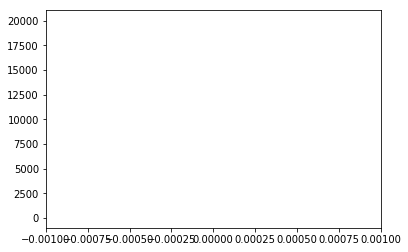

In [7]:
pd.DataFrame(holdings.sum(0)).plot()

pd.DataFrame(holdings.sum(1)).plot()

In [18]:
print(multiprocessing.get_start_method())

forkserver


In [24]:
multiprocessing.set_start_method('forkserver', force = True)
print(multiprocessing.get_start_method())
print("Changed start method")

forkserver
Changed start method


In [31]:
holdings = holdings_t[:]

In [32]:
%%time
# ('ward', 'average', 'complete', 'single'):

clusterer = AgglomerativeClustering(linkage='ward', n_clusters=4)

fit = clusterer.fit(holdings.toarray())

CPU times: user 4h 55min 4s, sys: 56.6 s, total: 4h 56min
Wall time: 4h 56min 40s


(array([35312.,     0.,     0.,    75.,     0.,     0.,   315.,     0.,
            0.,    89.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

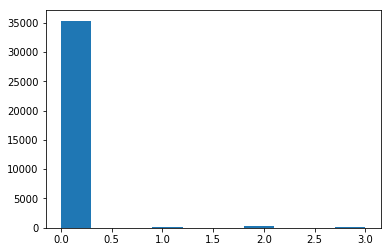

In [34]:
plt.hist(fit.labels_)

In [66]:
%%time
print('Start kMeans...')
ç = KMeans(n_clusters = 4,
                verbose = True,
                n_init = 8, # Number of runs
                n_jobs= -1,
                random_state=0).fit(holdings)

Start kMeans...
Initialization complete
Iteration  0, inertia 1055855141.295
Iteration  1, inertia 990517127.303
Iteration  2, inertia 989869262.132
Iteration  3, inertia 988398069.181
Iteration  4, inertia 986612112.731
Iteration  5, inertia 985106818.409
Iteration  6, inertia 983609385.082
Iteration  7, inertia 982040612.760
Iteration  8, inertia 980420117.536
Iteration  9, inertia 978388158.349
Iteration 10, inertia 976965042.532
Iteration 11, inertia 976201287.253
Iteration 12, inertia 976069592.251
Iteration 13, inertia 975603051.329
Iteration 14, inertia 975602165.989
Iteration 15, inertia 975602124.328
Converged at iteration 15: center shift 0.000000e+00 within tolerance 1.125847e-04
Initialization complete
Iteration  0, inertia 1045006945.581
Iteration  1, inertia 975118418.452
Iteration  2, inertia 974732639.219
Converged at iteration 2: center shift 0.000000e+00 within tolerance 1.125847e-04
Initialization complete
Iteration  0, inertia 1294290099.700
Iteration  1, inertia 98

In [70]:
lables = pd.DataFrame(kmeans.labels_)

In [74]:
lables.sample(10)

,0
26854,0
23096,0
14551,0
11598,0
8791,0
8358,0
22196,0
22112,0
2953,0
6215,0


In [49]:
summary = summary.loc[:1000,:]
summary['cluster'] = fit.labels_

pd.crosstab(summary['crsp_obj_cd'],summary['cluster'])# Samples per Fund -> weights per fund

ValueError: Length of values does not match length of index

In [ ]:
index = pd.DataFrame(np.arange(summary.shape[0]))

index = index.groupby(summary['port_no']).tail(20)

index = index.values.T.flatten()

summary = summary.loc[index,:]
holdings = holdings[index]
holdings.shape

#### Sonstiges

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 120395000000.00002
start iteration
done sorting
end inner loop
Iteration 1, inertia 120395000000.00002
center shift 0.000000e+00 within tolerance 9.598904e-01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 120395000000.00003
start iteration
done sorting
end inner loop
Iteration 1, inertia 120395000000.00003
center shift 0.000000e+00 within tolerance 9.598904e-01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 120394999999.99983
start iteration
done sorting
end inner loop
Iteration 1, inertia 120394999999.99983
center shift 0.000000e+00 within tolerance 9.598904e-01
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 120394999999.99979
start iteration
done sorting
end inner loop
Iteration 1, inertia 120394999999.99979
center shift 0.000000e+00 within tolerance 9.598904e-01
Initiali

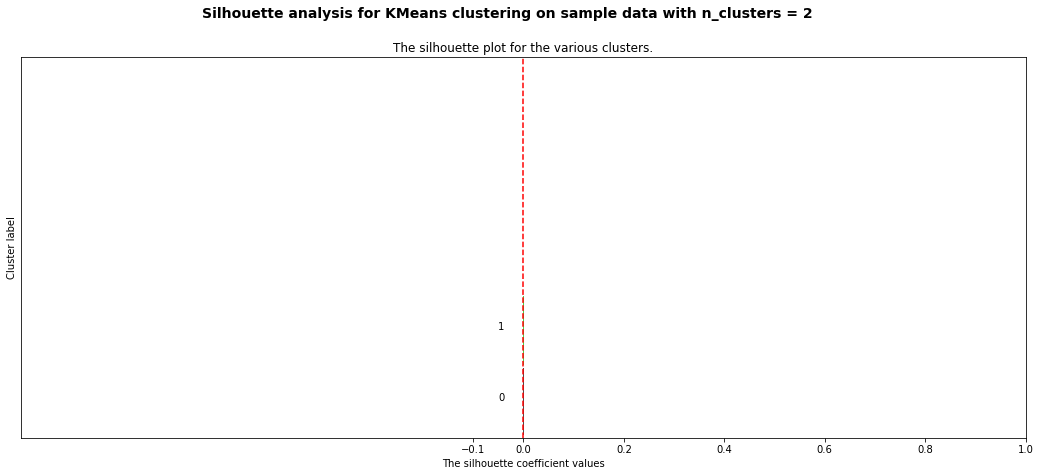

CPU times: user 10.3 s, sys: 1.34 s, total: 11.6 s
Wall time: 5.97 s


In [52]:
%%time

#X = holdings
n_clusters = [2]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = KMeans(n_clusters = 5,
                    verbose = True,
                    n_init = 10, # Number of runs
                    n_jobs= -1,
                    random_state=0)
    
    
    cluster_fit = clusterer.fit(X)
#    clusters.append(n_clusters)
#    results.append(cluster_fit.inertia_)    
    
    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Samples per Fund -> weights per fund

In [ ]:
index = pd.DataFrame(np.arange(summary.shape[0]))

In [ ]:
index = index.groupby(summary['port_no']).tail(20)

In [ ]:
index = index.values.T.flatten()

In [ ]:
summary = summary.loc[index,:]
holdings = holdings[index]
holdings.shape

#### Sonstiges

In [ ]:
result_mat = pd.DataFrame({'Clusters': clusters, 'Inertia':results})

In [ ]:
plt.plot(result_mat['Clusters'],result_mat['Inertia'])

# Visualize

In [ ]:
MiniBatchKMeans?

In [ ]:
%%time
holdings = holdings[:3000]
X = holdings
n_clusters = [4]

clusters = []
results = []



for n_clusters in n_clusters:
    clusterer = DBSCAN(
                        eps=0.5, 
                        min_samples=5, 
                        metric='euclidean', 
                        metric_params=None, 
                        leaf_size=50, 
                        p=None, 
                        n_jobs=-1)
    
    
    cluster_fit = clusterer.fit(holdings)
#    clusters.append(n_clusters)
#    results.append(cluster_fit.inertia_)    
    
    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()